In [2]:
from astropy.io import ascii
from MyToolkit import *
from Clustering_module import *
from astropy import units as u
from astropy.io import fits

DP2_DIRECTORY = "/home/vibin/MyFolder/WorkDesk/DP2/"

#### Pipeline building

In [32]:
def make_rand_from_dist(red_col, n_samples):
    bins = [2.901 + i*0.05 for i in range(50)]
    hist, edges = np.histogram(red_col, bins=bins)
    bin_widths = np.diff(edges)
    cdf = np.cumsum(hist * bin_widths) / np.sum(hist * bin_widths)
    #plt.stairs(cdf, bins)

    # Generate new z values that follow the histogram distribution
    uniform_values = np.random.rand(n_samples)
    bin_indices = np.searchsorted(cdf, uniform_values)
    bin_edges = edges[bin_indices-1]
    bin_diff = edges[bin_indices] - edges[bin_indices-1]
    bin_weights = (uniform_values - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])

    new_z_values = bin_edges + bin_weights * bin_diff

    return new_z_values

def make_shen_random_catalog_v2(ra_col, dec_col, red_col, init_level, mult):
    num_quasars = len(ra_col) * mult

    nside = 2 ** init_level

    map_now = healpix_sky_map_ps1_cover_area(ra_col, dec_col, init_level)
    map_now = map_now[1]

    ind = np.where(np.arange(num_quasars) > -1)
    rand_ra = np.zeros(num_quasars)
    rand_dec = np.zeros(num_quasars)

    while True:
        rand_ra[ind] = np.random.uniform(0, 360, len(ind[0]))
        rand_dec[ind] = np.degrees(np.arcsin(np.random.uniform(-0.5, 1, len(ind[0]))))     

        pix_of_points = hp.ang2pix(nside, np.absolute(np.radians(rand_dec) - np.pi/2), np.radians(rand_ra))
        ind = np.where(map_now[pix_of_points] == 0)

        if(len(ind[0]) == 0):
            break 

    rand_red = make_rand_from_dist(red_col, num_quasars)

    return rand_ra, rand_dec, rand_red

def make_shen_random_catalog(ra_col, dec_col, red_col, init_level, resol_upgrd, mult):
    num_quasars = len(ra_col) * mult

    map_now = healpix_sky_map_ps1_cover_area(ra_col, dec_col, init_level)
    map_now = map_now[1]

    map_then = hp.pixelfunc.ud_grade(map_now, 2 ** resol_upgrd)

    map_random = np.zeros_like(map_then)
    val_pos = np.where(map_then != 0)
    num_pix = len(val_pos[0])

    rand = np.random.randint(0, num_pix, num_quasars)
    rand_pos = val_pos[0][rand]
    map_random[rand_pos] = 1

    rand_ang = hp.pixelfunc.pix2ang(2**resol_upgrd, rand_pos, lonlat=True)

    rand_ra_col = rand_ang[0]
    rand_dec_col = rand_ang[1]

    rand_red_col = make_rand_from_dist(red_col, num_quasars)
    #plt.close()

    return rand_ra_col, rand_dec_col, rand_red_col

### Actual Shen quasar sample

##### Obtaining the Shen quasar sample

There are 4426 quasars in the catalog


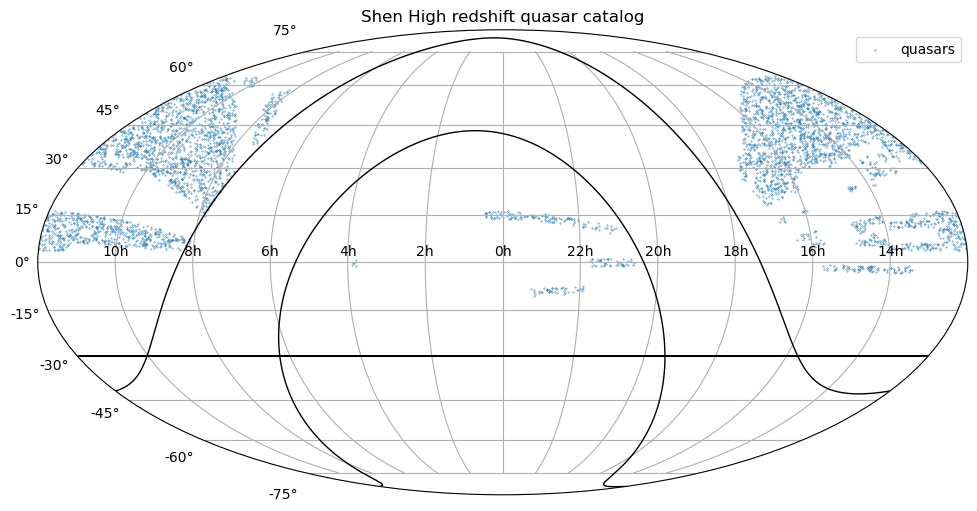

In [4]:
shen_file_name = DP2_DIRECTORY + "Data/shen_quasar_sample_datafile1.txt"
shen_data = ascii.read(shen_file_name)
sub_flag = shen_data.columns[8]
good_flag = shen_data.columns[9]
pos = np.where(sub_flag == 1)
pos_good = np.where(good_flag == 1)
ra_col_shen = shen_data.columns[3][pos].value
dec_col_shen = shen_data.columns[4][pos].value
red_col_shen = shen_data.columns[5][pos].value

ra_col_shen_good = shen_data.columns[3][pos_good].value
dec_col_shen_good = shen_data.columns[4][pos_good].value
red_col_shen_good = shen_data.columns[5][pos_good].value

print("There are {} quasars in the catalog".format(len(ra_col_shen)))
ax = plot_sky_map_ps1(ra_col_shen, dec_col_shen, labels=['quasars'], title="Shen High redshift quasar catalog", mark_size=0.1)

[2.901 2.951 3.001 3.051 3.101 3.151 3.201 3.251 3.301 3.351 3.401 3.451
 3.501 3.551 3.601 3.651 3.701 3.751 3.801 3.851 3.901 3.951 4.001 4.051
 4.101 4.151 4.201 4.251 4.301 4.351 4.401 4.451 4.501 4.551 4.601 4.651
 4.701 4.751 4.801 4.851 4.901 4.951 5.001 5.051 5.101 5.151 5.201 5.251
 5.301 5.351]


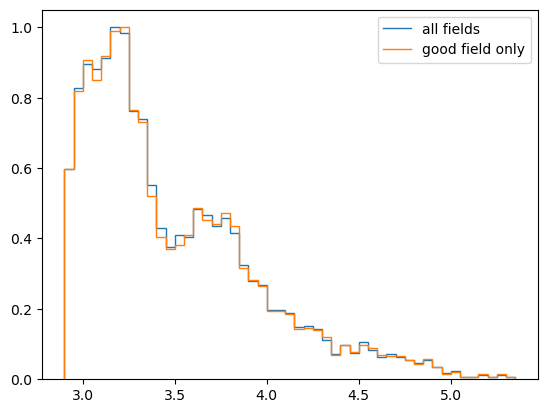

In [5]:
bins = [2.901 + i*0.05 for i in range(50)]
hist, edges = np.histogram(red_col_shen, bins=bins)
hist_good, edges_good = np.histogram(red_col_shen_good, bins=bins)
print(edges)
hist = hist/np.max(hist)
hist_good = hist_good/np.max(hist_good)

plt.stairs(hist, edges, label="all fields")
plt.stairs(hist_good, edges, label="good field only")
plt.legend()

##### Finding the footprint

Level    coverage area
    3      8594.36693
    4      5962.34206
    5      4407.97022
    6      2444.86239
    7      826.70424
    8      224.93070
    9      57.51784
   10      14.49093
[8594.366926962348, 5962.3420555801285, 4407.970224649048, 2444.862388500129, 826.7042405329993, 224.9306969165927, 57.517842623377774, 14.490929343099051]


Text(0, 0.5, 'Effective coverage area')

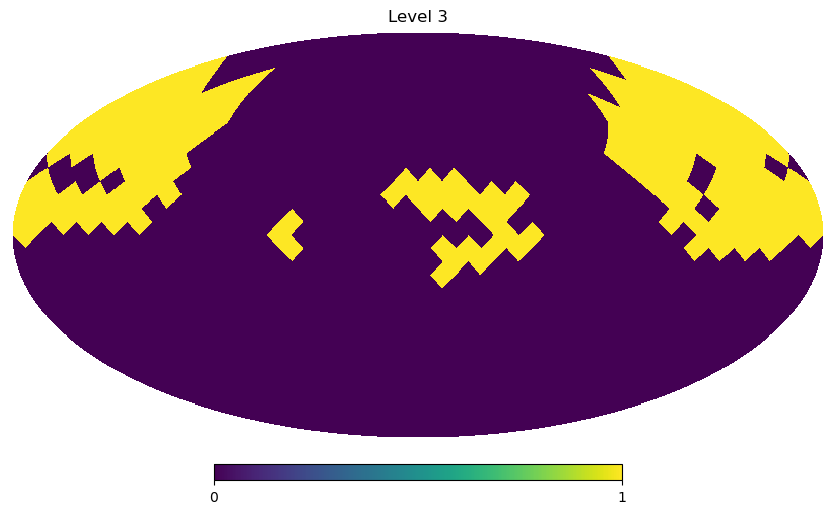

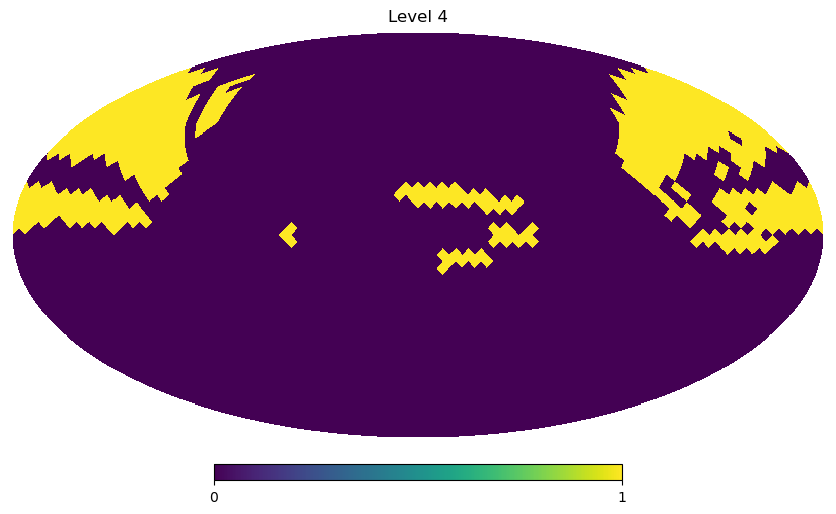

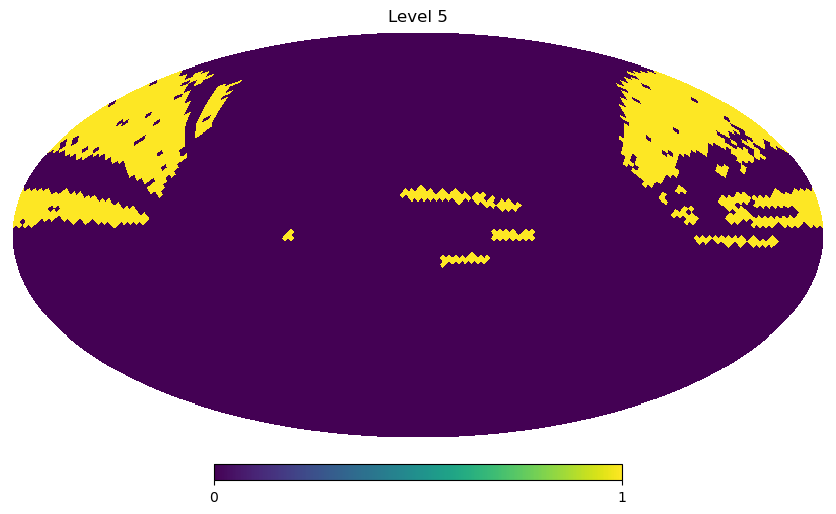

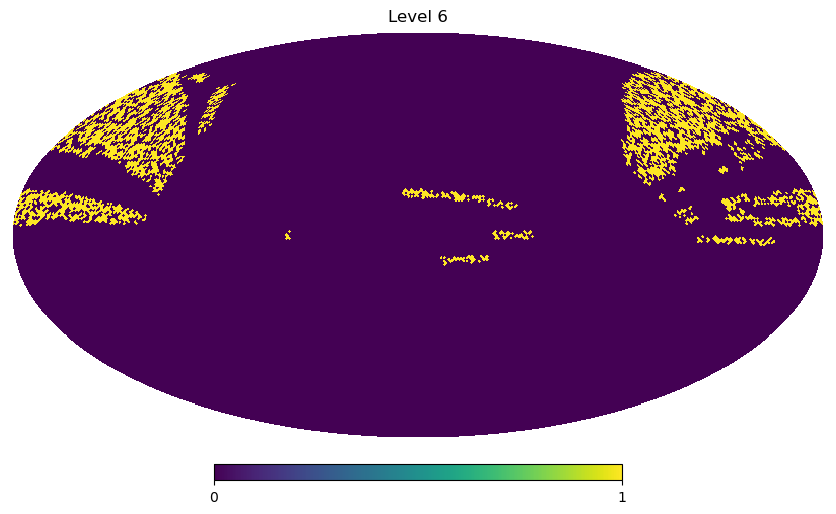

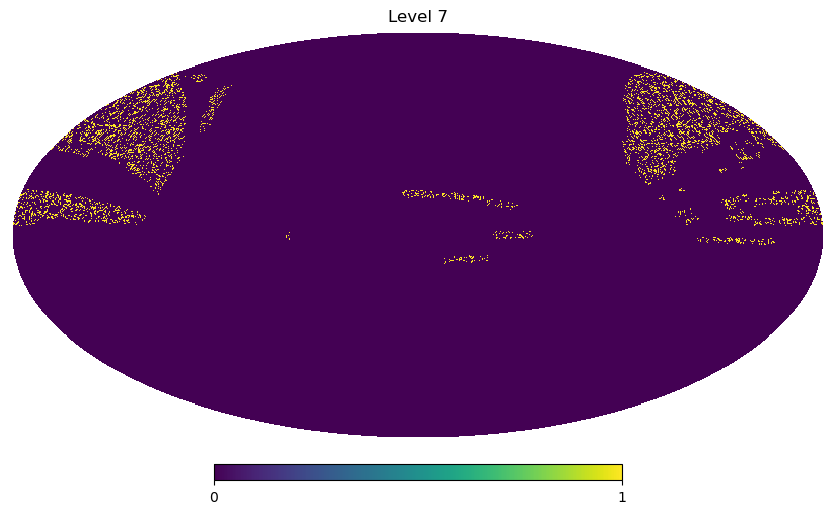

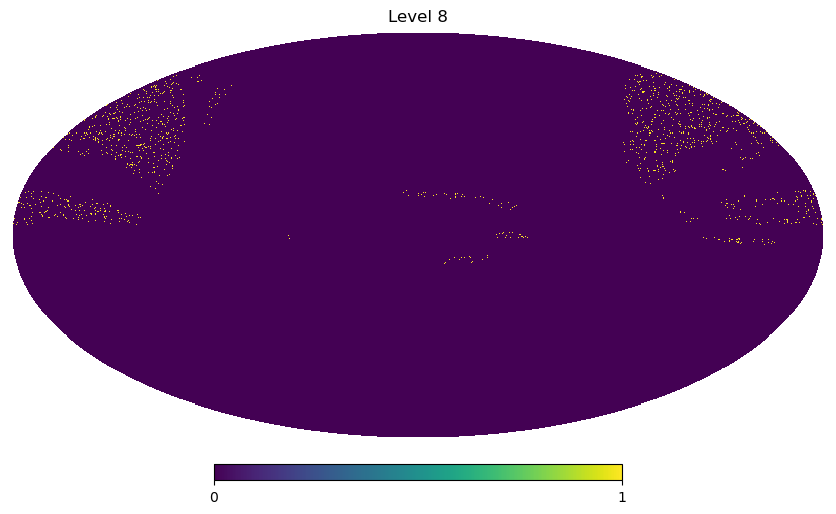

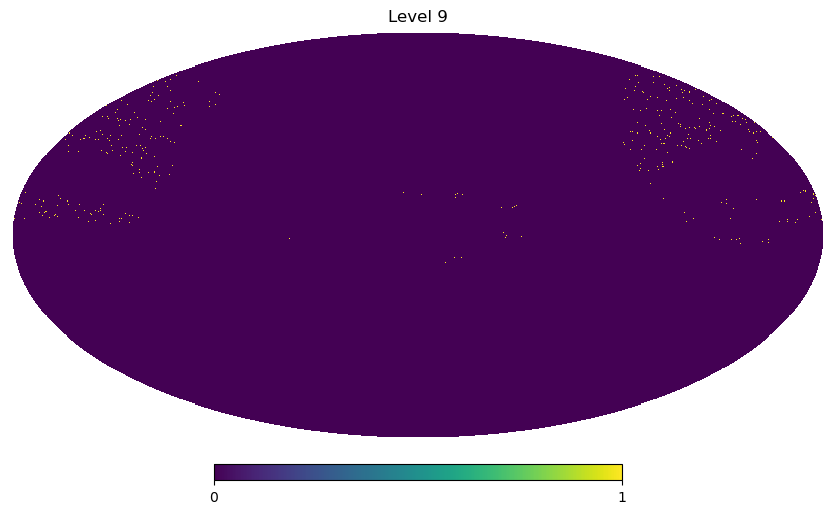

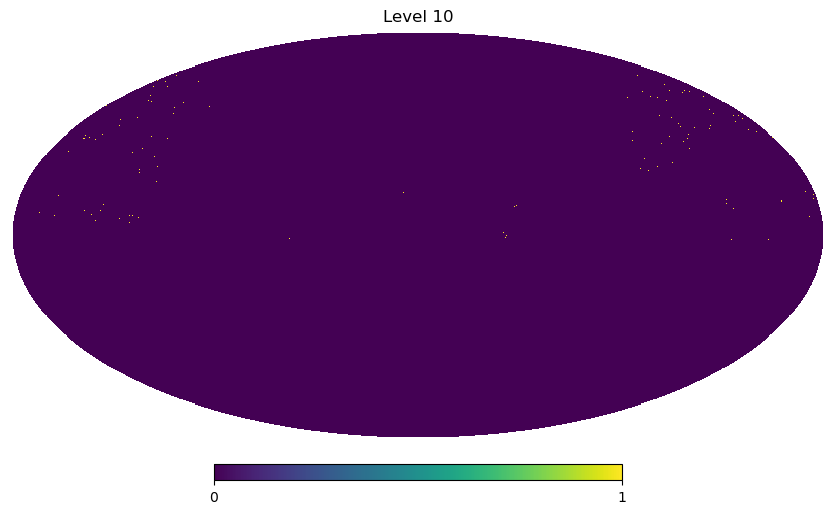

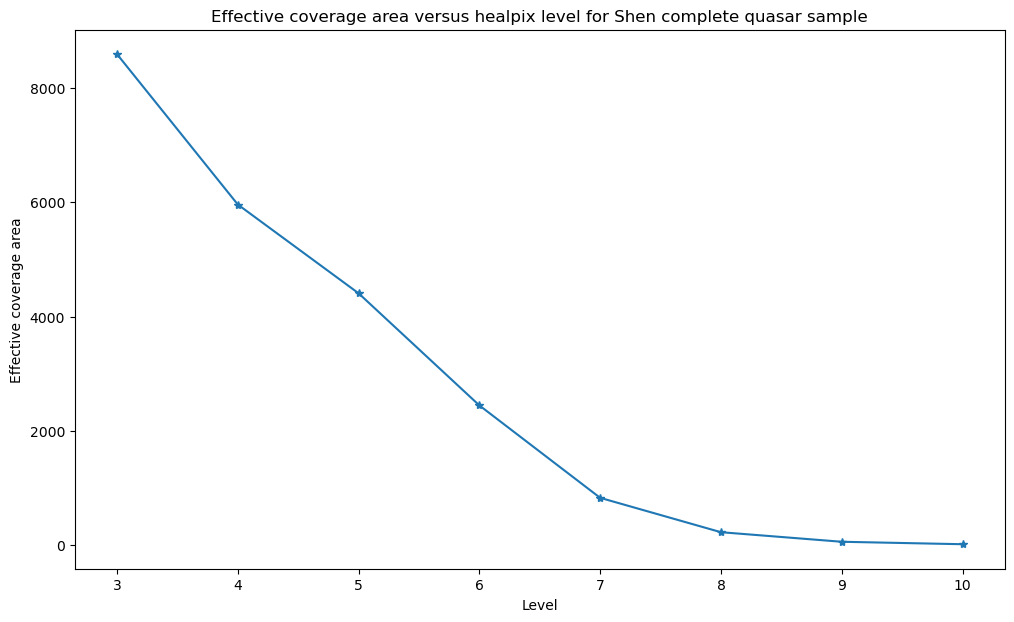

In [6]:
level = []
cov_area = []
print("Level    coverage area")
for i in [3,4,5,6,7,8,9,10]:
    map_i, wat = healpix_sky_map_ps1_cover_area(ra_col_shen, dec_col_shen, i, title="Level " + str(i))
    level.append(i)
    cov_area.append(map_i)
    print(f'{i:5d}      {map_i:8.5f}')

print(cov_area)
fig, ax = plt.subplots(figsize = (12, 7))
ax.plot(level, cov_area, '*-')
ax.set_title("Effective coverage area versus healpix level for Shen complete quasar sample")
ax.set_xlabel("Level")
ax.set_ylabel("Effective coverage area")

##### Finding the redshift space clustering

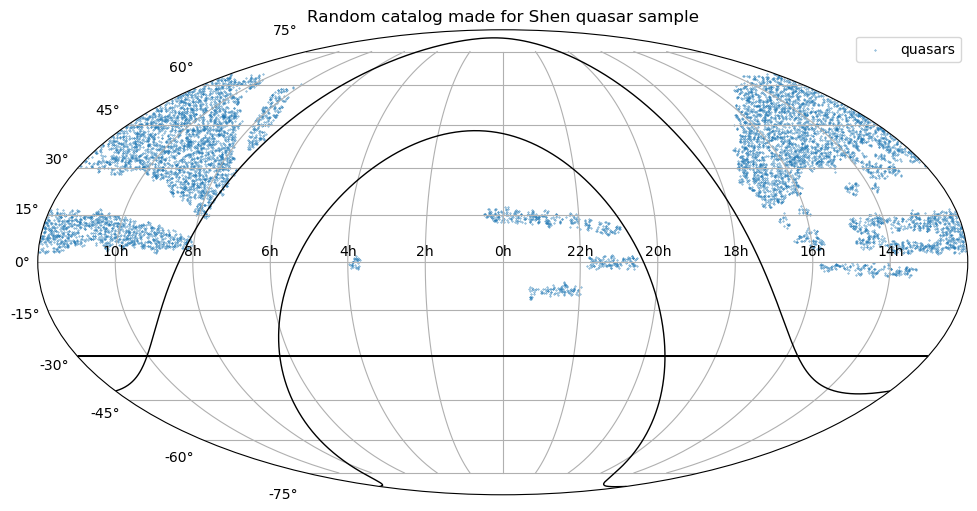

<MollweideAxes: title={'center': 'Random catalog made for Shen quasar sample'}>

In [34]:
rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen = make_shen_random_catalog(ra_col_shen, dec_col_shen, red_col_shen, 5, 11, 2)
plt.close()

plot_sky_map_ps1(rand_ra_col_shen, rand_dec_col_shen, labels=['quasars'], title="Random catalog made for Shen quasar sample", mark_size=0.1)

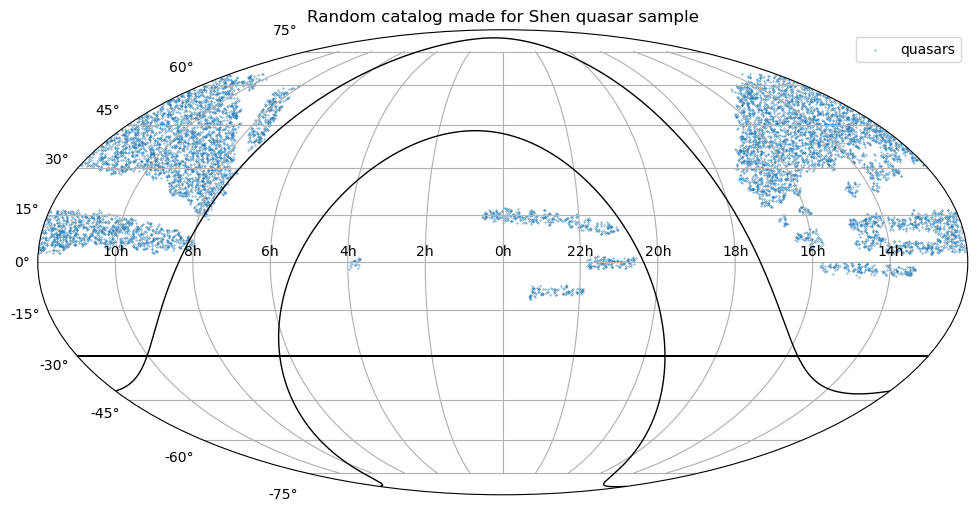

<MollweideAxes: title={'center': 'Random catalog made for Shen quasar sample'}>

In [35]:
### Random catalog making v2

rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen = make_shen_random_catalog_v2(ra_col_shen, dec_col_shen, red_col_shen, 5, 2)
plt.close()

plot_sky_map_ps1(rand_ra_col_shen, rand_dec_col_shen, labels=['quasars'], title="Random catalog made for Shen quasar sample", mark_size=0.1)

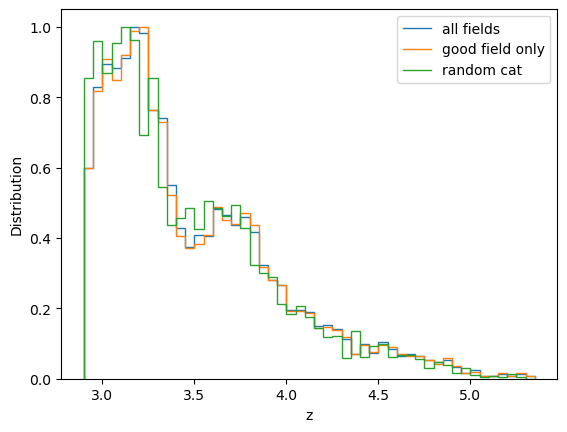

In [8]:
bins = [2.901 + i*0.05 for i in range(50)]
hist, edges = np.histogram(red_col_shen, bins=bins)
hist_good, edges_good = np.histogram(red_col_shen_good, bins=bins)

hist_rand, edges_rand = np.histogram(rand_red_col_shen, bins=bins)

#print(edges)
hist = hist/np.max(hist)
hist_good = hist_good/np.max(hist_good)
hist_rand = hist_rand/np.max(hist_rand)

plt.stairs(hist, edges, label="all fields")
plt.stairs(hist_good, edges, label="good field only")
plt.stairs(hist_rand, edges, label="random cat")
plt.xlabel('z')
plt.ylabel('Distribution')
plt.legend()

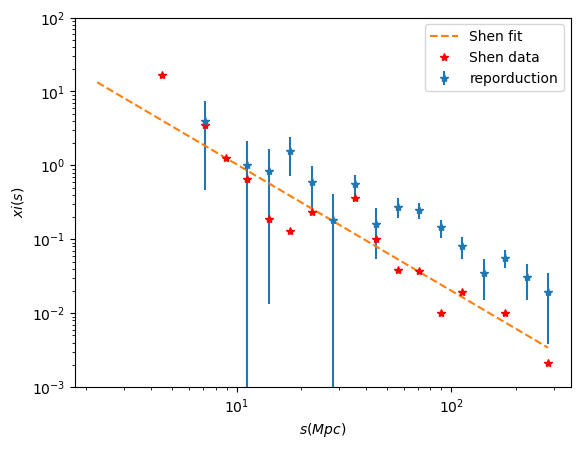

In [39]:
# rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen = make_shen_random_catalog(ra_col_shen, dec_col_shen, red_col_shen, 5, 11, 1)
# plt.close()

### Trying the clustering with the v2 of random catalog maker
rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen = make_shen_random_catalog_v2(ra_col_shen, dec_col_shen, red_col_shen, 5, 2)
plt.close()

fig, ax = find_xi_s(ra_col_shen, dec_col_shen, red_col_shen, "shen_redshift_space_corr_table_real_signal", rand_ra=rand_ra_col_shen, rand_dec=rand_dec_col_shen, rand_red=rand_red_col_shen)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(0.001, 100)

s_bins = np.logspace(start=np.log10(1.9868), stop=np.log10(314.915), num=23)
s_mid = (s_bins[:-1] + s_bins[1:])/2

original = ma.masked_values([0, 0, 0, 16.5, 0, 3.54, 1.26, 0.663, 0.191, 0.131, 0.236, 0, 0.361, 0.101, 0.0384, 0.0368, 0.0101, 0.0194, 0, 0.0101, 0, 0.00214], 0)

fit_clust = pow(s_mid/ 10.2, -1.71)

ax.plot(s_mid, fit_clust, '--', label="Shen fit")
ax.plot(s_mid, original, 'r*', label="Shen data")

ax.legend()

In [10]:
s_bins = np.logspace(start=np.log10(1.9868), stop=np.log10(314.915), num=23)
s_mid = (s_bins[:-1] + s_bins[1:])/2

s_array = find_s_bined(ra_col_shen, dec_col_shen, red_col_shen)

s_hist, edges = np.histogram(s_array, s_bins)

[       nan        nan        nan 0.1               nan 0.1
 0.1        0.1        0.1        0.01111111 0.15555556 0.13846154
 0.03150685 0.1034188  0.08701299 0.09245283 0.09021066 0.09738854
 0.10035063 0.10545455 0.11122323 0.11608468]


/tmp/ipykernel_10367/3800546686.py:8: RuntimeWarning: invalid value encountered in divide
  print((s_hist - s_hist_original)/s_hist)


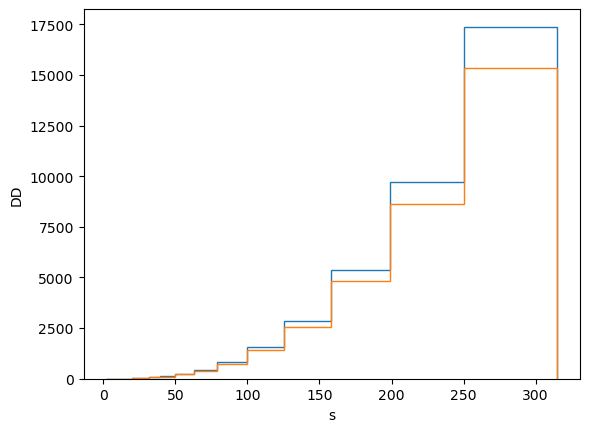

In [11]:
s_hist_original = np.array([0.0, 0.0, 0.0, 1.8, 0.0, 1.8, 1.8, 2.7, 4.5, 8.9, 15.2, 22.4, 70.7, 104.9, 210.9, 384.8, 734.2, 1417.1, 2565.8, 4821.6, 8631.8, 15365.1])

plt.stairs(s_hist, s_bins)
plt.stairs(s_hist_original, s_bins)
plt.xlabel('s')
plt.ylabel('DD')

print((s_hist - s_hist_original)/s_hist)

##### Dealing with the quasar selection function as given in Richards et al 2006.

In [12]:
sdss_sel_fun_file_name = DP2_DIRECTORY + 'Data/sdss_q_sel_fun_richards.dat'
sdss_sel_fun_file = open(sdss_sel_fun_file_name, 'r')
sdss_sel_fun = np.genfromtxt(sdss_sel_fun_file)

sel_fun_imag_col = sdss_sel_fun[:,0]
sel_fun_z_col = sdss_sel_fun[:,1]
sel_fun_point_col = sdss_sel_fun[:,2]
sel_fun_radio_col = sdss_sel_fun[:,3]
sel_fun_extended_col = sdss_sel_fun[:,4]

### selection function is given in the following way: 53 i magnitudes are there from 15.0 to 20.2, difference of 0.1, for each magnitude 121 z values 
# from 0.0 to 6.0 is given with difference of 0.05.

sel_fun_z = sel_fun_z_col[0:121]
sel_fun_imag = np.reshape(sel_fun_imag_col, (53,121))[:,0]
sel_fun_point_val = np.average(np.reshape(sel_fun_point_col,(53, 121)), axis=0)
sel_fun_point_grid = np.reshape(sel_fun_point_col,(53, 121))
sel_fun_radio_val = np.average(np.reshape(sel_fun_radio_col,(53, 121)), axis=0)
sel_fun_ext_val = np.average(np.reshape(sel_fun_extended_col,(53, 121)), axis=0)

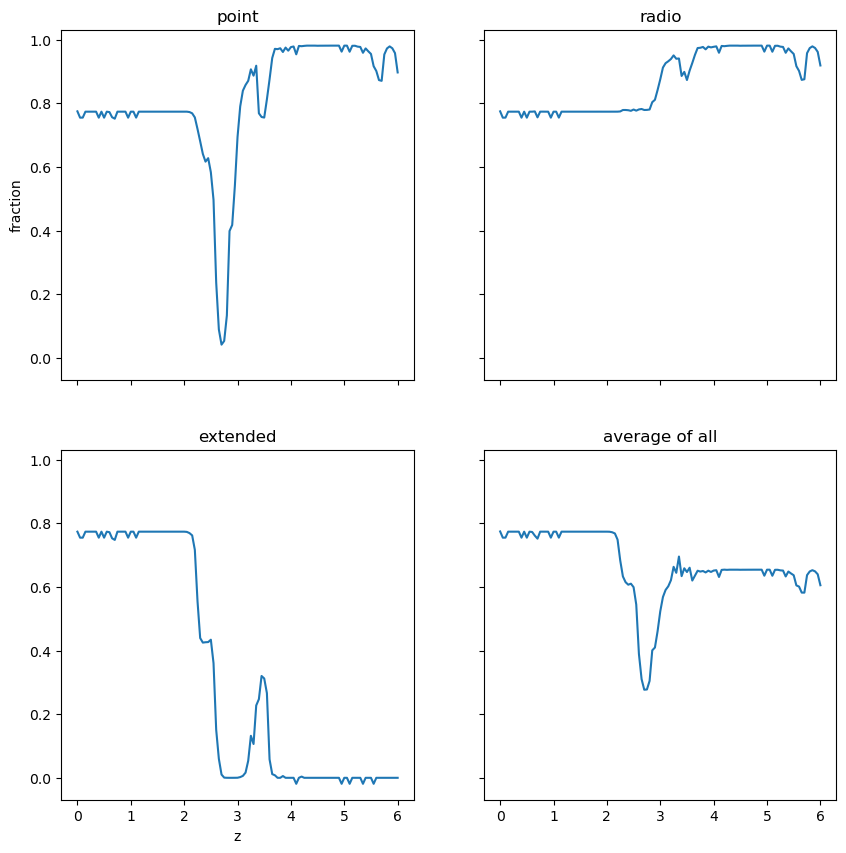

In [13]:
fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)
ax1.plot(sel_fun_z, sel_fun_point_val)
ax1.set_title('point')
ax2.plot(sel_fun_z, sel_fun_radio_val)
ax2.set_title('radio')
ax3.plot(sel_fun_z, sel_fun_ext_val)
ax3.set_title('extended')
ax4.plot(sel_fun_z, (sel_fun_point_val + sel_fun_radio_val + sel_fun_ext_val)/3)
ax4.set_title('average of all')
ax3.set_xlabel('z')
ax1.set_ylabel('fraction')
plt.show()

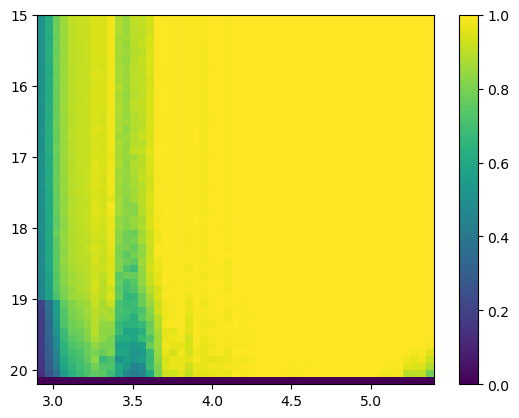

In [14]:
loc_z = (sel_fun_z >= 2.9) & (sel_fun_z <= 5.4)
sel_fun_point_grid_real = sel_fun_point_grid[:,loc_z].T
sel_fun_z_real = sel_fun_z[loc_z]

im_sel = plt.imshow(sel_fun_point_grid_real.T, extent=[sel_fun_z_real.min(), sel_fun_z_real.max(), sel_fun_imag.max(), sel_fun_imag.min()], aspect='auto', vmin=0)
plt.colorbar(im_sel)

In [15]:
sel_fun_point_grid_real.shape

(51, 53)

##### QLF from Richards et al 2006

In [16]:
from astropy.cosmology import LambdaCDM as LCDM
cosmo = LCDM(H0=70, Om0=0.3, Ode0=0.7)  ## they could have calculated luminosity distance differently
d_z2 = cosmo.luminosity_distance(z=2)

def QLF_phi_app(m, z, **kwargs):
    M_z2 = m - 5 * np.log10(cosmo.luminosity_distance(z=z)/d_z2)
    phi_ast = pow(10, kwargs['log_phi_ast'])
    zeta = np.log10((1+z)/(1+kwargs['z_ref']))
    mu = M_z2 - (kwargs['M_ast'] + kwargs['B1']*zeta + kwargs['B2']*pow(zeta,2) + kwargs['B3']*pow(zeta,3))
    phi = phi_ast * pow(10, mu* (kwargs['A1'] + kwargs['A2'] * (z - 2.45)))

    return phi

def QLF_phi_abs(M, z, **kwargs):
    phi_ast = pow(10, kwargs['log_phi_ast'])
    zeta = np.log10((1+z)/(1+kwargs['z_ref']))
    mu = M - (kwargs['M_ast'] + kwargs['B1']*zeta + kwargs['B2']*pow(zeta,2) + kwargs['B3']*pow(zeta,3))
    phi = phi_ast * pow(10, mu* (kwargs['A1'] + kwargs['A2'] * (z - 2.45)))

    return phi   


In [17]:
m = 15
M_z2 = m - 5 * np.log10(cosmo.luminosity_distance(z=4)/d_z2)
M_z2

<Quantity 13.18464048>

/home/vibin/anaconda3/envs/dp2/lib/python3.10/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


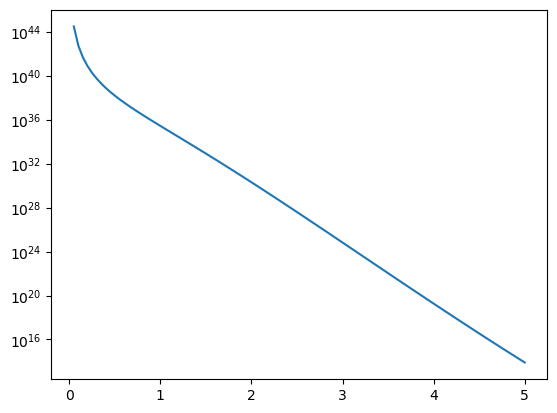

In [18]:
keywords = {'A1':0.83, 'A2':-0.11, 'B1':1.43, 'B2':36.63, 'B3':34.39, 'M_ast':-26, 'z_ref':2.45, 'log_phi_ast':-5.70}

z_array = np.linspace(0, 5, 100)
phi_array = QLF_phi_app(15, z_array, **keywords)

plt.plot(z_array, phi_array)
plt.yscale('log')

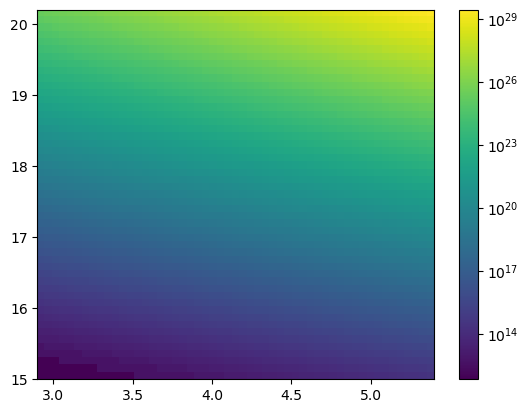

In [19]:
m_array = sel_fun_imag
z_array = sel_fun_z[(sel_fun_z >= 2.9) & (sel_fun_z <= 5.4)]
m_grid, z_grid = np.meshgrid(m_array, z_array)
phi_array1 = QLF_phi_app(m_grid, z_grid, **keywords)

im = plt.imshow(phi_array1, extent=[z_array.min(), z_array.max(), m_array.min(), m_array.max()], norm='log', aspect='auto')
plt.colorbar(im)

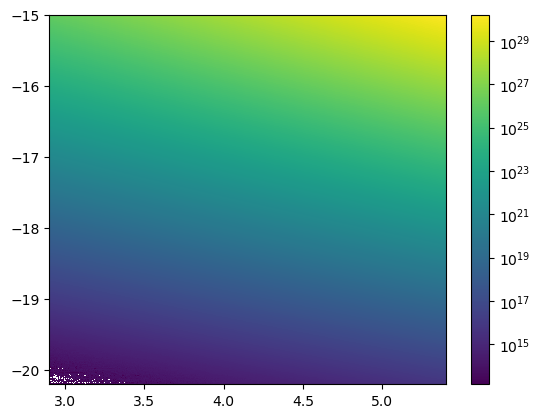

In [20]:
M_array = np.linspace(-15.0, -20.2, 100)
z_array = np.linspace(2.9, 5.4, 1000)

M_grid, z_grid = np.meshgrid(m_array, z_array)
phi_array2 = QLF_phi_abs(M_grid, z_grid, **keywords)

im1 = plt.imshow(phi_array2, extent=[z_array.min(), z_array.max(), M_array.min(), M_array.max()], norm='log', aspect='auto')
plt.colorbar(im1)

ValueError: x and y must have same first dimension, but have shapes (1000,) and (51,)

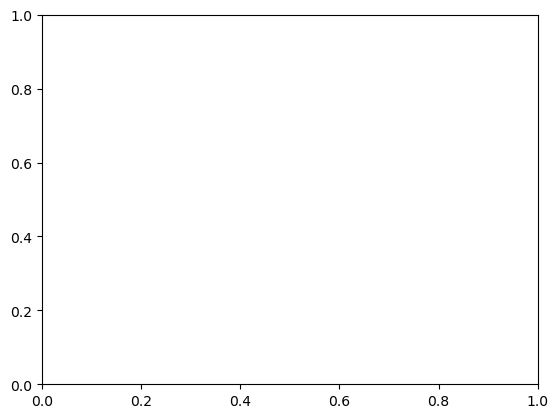

In [21]:
int_phi_z = np.sum(phi_array1, axis=1)*(m_array[0] - m_array[1])

plt.plot(z_array,int_phi_z)